In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2
from sklearn.metrics import balanced_accuracy_score, adjusted_mutual_info_score, brier_score_loss, mutual_info_score, accuracy_score
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from collections import defaultdict

In [2]:
import os

data_dir = "../data"
all_preds_path = os.path.join(data_dir, "results", "Alternate_target_results", "all_preds.tsv.gz")
uk_metadata_path = os.path.join(data_dir, "UK_dataset", "metadata.tsv.gz")
africa_metadata_path = os.path.join(data_dir, "African_dataset", "metadata.tsv.gz")

In [3]:
metadata = pd.concat([
    pd.read_csv(path, sep="\t", index_col=0)
    for path in [uk_metadata_path, africa_metadata_path]
])
metadata.index = metadata.index.astype(str)

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
grouper = ['task', 'target', 'dataset', 'subtype', 'shorthand']
task_order = ['all features\nkept', 'DRM features\nremoved']
target_order = ['encoded_label', 'hasDRM']

# Data cleaning / gathering
You can skip this ig the avove cells read precomputed tsv files

In [5]:
dirname = 'whole_dataset_multi_targets'
# all_preds = pd.read_csv(os.path.join(dirname, 'all_preds.tsv'), sep='\t', index_col=0)
all_preds = pd.read_csv(all_preds_path, sep='\t', index_col=0)
all_preds['shorthand'] = all_preds['shorthand'].apply(lambda x: {'B1': 'FC'}.get(x,x))
dirname = 'whole_dataset_figure_results_RAM'

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
subset_preds = all_preds[
                (all_preds['task'].isin(task_order)) & 
                (
                    ((all_preds['dataset'] == 'UK') & (all_preds['subtype'].isin(['B', 'C']))) |
                    ((all_preds['dataset'] == 'Africa') & (all_preds['subtype'] == 'ALL'))
                )
            ]

In [7]:
# metadata = pd.concat(
#     [pd.read_csv(os.path.join('/Users/lucblassel/Documents/Work/hiv-drm-detection/data_pre_split',name), sep='\t', index_col=0)
#     for name in ['uk-metadata.tsv', 'africa-metadata.tsv']]
# )
# metadata.index = metadata.index.astype(str)

In [8]:
subset_preds.index = subset_preds.index.astype(str)
subset_preds['encoded_label'] = metadata['encoded_label']

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Computing scores 
We need to compute AMI and/or balanced accuracy for the RF/LR/NB and fisher test based classifier on the 3 tasks. showing everything: 
 - trained on B, tested on C
 - trained on C, tested on B
 - trained on ALL, tested on Africa
 

In [9]:
def get_scores(df):
    scorer = {'AMI':adjusted_mutual_info_score, 'bal acc':balanced_accuracy_score, 'accuracy':accuracy_score}
    scores = {}
    for name, function in scorer.items():
        scores[name] = function(df['real'], df['pred'])
    return pd.Series(scores)

In [10]:
def get_pvalue(df):
    N = df.shape[0]
    m_i = mutual_info_score(df['real'], df['pred'])
    G_stat = m_i * 2 * N 
    return 1 - chi2.cdf(G_stat, df=1)

scores_cleaned: the sequences with DRMs are removed from the test set for models trained without them 

In [11]:
scores = subset_preds.groupby(grouper).apply(get_scores)
p_values = subset_preds.groupby(grouper).apply(get_pvalue).rename('p_value').reset_index()
melted = pd.melt(scores.reset_index(), id_vars=grouper)
melted['group'] = melted['task'] + ' ' + melted['subtype']
melted['group2'] = melted['target'] + ' ' + melted['subtype']

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: Future

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: Future

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: Future

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: Future

/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/usr/local/Caskroom/miniconda/base/envs/HIV/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: Future

In [12]:
def bonferroni(df, alpha=0.05):
    N = df.shape[0]
    df['bonferroni'] = df['p_value'] <= (alpha / N)
    return df

In [13]:
corrected = p_values.groupby('subtype').apply(bonferroni).set_index(['subtype', 'task', 'shorthand', 'target'])

## Plot preparation

In [14]:
models = ['NB', 'LR', 'RF', 'FC']
subtypes = ['ALL', 'B', 'C']
subtype_labels = {
    'ALL': 'trained on UK B&C,\ntested on Africa',
    'B': 'trained on UK B,\ntested on UK C',
    'C': 'trained on UK C,\ntested on UK B'
}

In [15]:
colors = [color for color in sns.palettes.color_palette('muted') for _ in range(3)]
hue_order = [f"{task} {sub}" for task in task_order for sub in subtypes]

In [16]:
repeats = {'big': 3, 'small':4}
patterns = {k:{'B':'/'*n, 'C': '\\'*n} for k,n in repeats.items()} 
hatches = [patterns['big'].get(sub, None) for task in task_order for sub in subtypes for model in models]
small_hatches = [patterns['small'].get(sub, None) for task in task_order for sub in subtypes for model in models]
hatches_multi = [patterns['big'].get(sub, None) for sub in subtypes for target in target_order for model in models]
small_hatches_multi = [patterns['small'].get(sub, None) for sub in subtypes for target in target_order for model in models]
models_ext = models + ['RD']
hatches_ext = [patterns.get(sub, None) for task in task_order for sub in subtypes for model in models_ext]

In [17]:
sns.set_context('poster')
sns.set_palette('muted')

In [18]:
def get_legend(gen_label=False, context='notebook', hue='task'):
    with sns.plotting_context(context):
        hues = {
            'task': ['all features\nkept\n', 'RAM features\nremoved\n'],
            'target': ['\ntreated vs. naive\n', '\nw/ RAM vs. wo/ RAM\n']
        }
        h1 = [Patch(facecolor=color, label=label, edgecolor='black') 
                for label, color in zip(hues.get(hue, []), sns.color_palette())]
        h2 = [Patch(facecolor="white",label=subtype_labels.get(subtype),hatch=patterns['small'].get(subtype, ""), 
                edgecolor='black',) for subtype in subtypes]
        l = Line2D([0], [0], color='red', label="expected value\nfor null classifier\n")
        e = Patch(color='white', label="")
        labels = [Patch(color="white", label="signal removal:\n\n"), Patch(color="white", label="training scenario:\n")]
    (ncol, handles) = (5, labels) if gen_label else (3, [])
    return (ncol, 
        handles + [h1[0], h2[0]] + [h1[1], h2[1]] + [l, h2[2]]
    )

# Plotting scores

In [19]:
def get_subplot(to_plot, ylabel, annots=None, x='shorthand', y='value', hue='group', order=models, palette=colors, hue_order=hue_order, hatches=hatches, ax=None, title="", title_args=dict(), yticks=None, ylim=None, log=False, xlabel="Classifier"):
    
    kwargs={'ax':ax} if ax is not None else {}
        
    ax = sns.barplot(
        data=to_plot, 
        x=x, 
        y=y,
        hue=hue, 
        order=order,
        hue_order=hue_order, 
        palette=palette, 
        # lw=1.2,
        edgecolor='black',
        ci=None,
        **kwargs
    )
    if annots is None:
        annots = ["" for _ in hatches]
    for patch, hatch, annot in zip(ax.patches, hatches, annots):
        if annot == "*":
            x = patch.get_x() + patch.get_width() / 2
            if log:
                y = (patch.get_y() + patch.get_height()) * 1.05
            else:
                y = (patch.get_y() + patch.get_height()) + 0.01
            ax.text(x, y, annot, ha='center', va='center')
        if hatch is None:
            continue 
        patch.set_hatch(hatch)

    sns.despine()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.get_legend().remove()
    ax.set_title(title, **title_args)
    if yticks is not None:
        ax.set_yticks(yticks)
    if log:
        ax.set_yscale('log')
    if ylim is not None:
        ax.set_ylim(ylim)
    return ax

In [20]:
def draw_brace(ax, xspan, yy, text):
    """Draws an annotated brace on the axes."""
    xmin, xmax = xspan
    xspan = xmax - xmin
    ax_xmin, ax_xmax = ax.get_xlim()
    xax_span = ax_xmax - ax_xmin

    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin
    resolution = int(xspan/xax_span*100)*2+1 # guaranteed uneven
    beta = 300./xax_span # the higher this is, the smaller the radius

    x = np.linspace(xmin, xmax, resolution)
    x_half = x[:int(resolution/2)+1]
    y_half_brace = (1/(1.+np.exp(-beta*(x_half-x_half[0])))
                    + 1/(1.+np.exp(-beta*(x_half-x_half[-1]))))
    y = np.concatenate((y_half_brace, y_half_brace[-2::-1]))
    y = yy + (.05*y - .01)*yspan # adjust vertical position

    ax.autoscale(False)
    ax.plot(x, y, color='black', lw=1)

    ax.text((xmax+xmin)/2., yy+.07*yspan, text, ha='center', va='bottom', rotation='vertical')

FileNotFoundError: [Errno 2] No such file or directory: 'whole_dataset_figure_results_RAM/performance_compare_tasks.pdf'

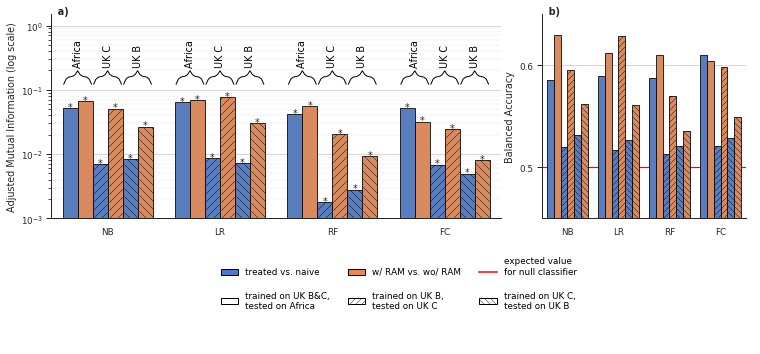

In [21]:
sns.set_context('paper')
mpl.rcParams['hatch.linewidth'] = 0.4
mult = 1.5
fig = plt.figure(figsize=(8.3 * mult, 5.8))
annots = ["*" if corrected['bonferroni'].get((sub, task_order[1], model, target), False) else ""
                for sub in subtypes for target in target_order for model in models]
title_args = {'loc':'left', 'fontweight':'bold', 'pad':0}
hue_order_multi = [f"{target} {subtype}" for subtype in subtypes for target in target_order]
colors_multi = [col for _ in subtypes for col in (sns.color_palette()[:2])]
ami_ticks = np.linspace(0, 0.55, 12)
acc_ticks = np.linspace(0.5, 0.6, 2)

to_plot_AMI = melted[(melted['shorthand'].isin(models)) & (melted['variable'] == 'AMI') & (melted['task'] == task_order[1])]
to_plot_bal = melted[(melted['shorthand'].isin(models)) & (melted['variable'] == 'bal acc') & (melted['task'] == task_order[1])]

with sns.axes_style('white', {'grid.color':'.8', 'axes.grid':True, 'ytick.left':True}):
    ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=2, colspan=2)
    get_subplot(to_plot_AMI, 'Adjusted Mutual Information (log scale)', annots=annots, ax=ax1, title='  a)', 
                title_args=title_args, yticks=ami_ticks, ylim=(1e-3, 1.5), log=True, hue='group2', hue_order=hue_order_multi, hatches=hatches_multi, palette=colors_multi, xlabel="")
    ax2 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)
    ax2.axhline(y=0.5, ls='-', color='red', zorder=0.9)
    get_subplot(to_plot_bal, 'Balanced Accuracy', ax=ax2, title='  b)', title_args=title_args, 
                yticks=acc_ticks, hatches=small_hatches_multi, ylim=(0.45,0.65), xlabel="", hue='group2', hue_order=hue_order_multi, palette=colors_multi)

ax1.grid(b=True, which='minor', color='.8', lw=0.2)

patch_order = [(sub, model) for sub in subtypes for target in target_order for model in models ]
brace_xs = defaultdict(list)

for patch, (sub, model) in zip(ax1.patches, patch_order):
    brace_xs[(sub, model)].append((patch.get_x(), patch.get_width()))

for (sub, _), pos in brace_xs.items():
    draw_brace(ax1, (pos[0][0]+0.01, sum(pos[1])-0.01), 0.1, {'ALL': ' Africa', 'B': ' UK C', 'C': ' UK B'}.get(sub))

ax3 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
ax3.axis('off')

ncol, handles = get_legend(hue='target')
ax3.legend(handles=handles, ncol=ncol,  bbox_to_anchor=(0.5, 0.5), loc='center', borderaxespad=0, frameon=False)
fig.savefig(os.path.join(dirname, 'performance_compare_tasks.pdf'), format='pdf', alpha=.99, bbox_inches='tight')
fig.savefig(os.path.join(dirname, 'performance_compare_tasks.eps'), format='eps', alpha=.99, bbox_inches='tight')